In [39]:
# toggle code cells
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from jupyterthemes import jtplot

In [2]:
sys.path.insert(0, "C://Users/elliott.good/Desktop/Python Scripts")
import SQL_query as sql

In [3]:
jtplot.style("chesterish")

In [4]:
youtube_qry = '''
-- user signups
WITH signups AS (
	SELECT s.user_id
		,u.country
		,DATE(u.signupdate) AS signupdate
		,CASE WHEN s.subs < 100000 THEN '<100k'
			  WHEN s.subs < 500000 THEN '100k - 500k'
			  WHEN s.subs < 1000000 THEN '500k - 1M'
			  WHEN s.subs < 5000000 THEN '1M - 5M'
			  WHEN s.subs > 5000000 THEN '>5M'
			  ELSE 'Not Listed' END AS subs
	FROM (
		SELECT gmc.user_id
			,MAX(yc.subscriber_count) AS subs
		FROM youtube_channels yc
		LEFT JOIN gmc_merchants gmc ON yc.gmc_merchant_id = gmc.id
        WHERE yc.subscriber_count >= 10000
		GROUP BY 1
		) s
	LEFT JOIN users u ON s.user_id = u.id
	WHERE u.signupdate >= DATE('2018-1-1')
	),

-- campaigns launched
user_campaigns AS ( 
	SELECT s.*
		,SUM(CASE WHEN cf.url IS NOT NULL THEN 1 ELSE 0 END) AS campaigns
	FROM signups s
	LEFT JOIN rollups.campaign_facts cf ON s.user_id = cf.user_id
	WHERE cf.campaign_state_id <> 0
	GROUP BY 1,2,3,4
	),
	
-- units captured
user_sales AS (
	SELECT s.*
		,SUM(CASE WHEN so.order_id IS NOT NULL THEN so.quantity ELSE 0 END) AS units
	FROM signups s
	LEFT JOIN rollups.super_orders so ON s.user_id = so.seller_id
	WHERE so.order_state_id = 3
	GROUP BY 1,2,3,4
	)

	
-- campaigns launched
SELECT s.user_id
	,s.country
	,s.signupdate
	,s.subs
	,COALESCE(c.campaigns, 0) AS campaigns
	,COALESCE(u.units, 0) AS units
FROM signups s 
LEFT JOIN user_campaigns c ON s.user_id = c.user_id
LEFT JOIN user_sales u ON s.user_id = u.user_id
'''

In [10]:
youtube_stats = sql.connect_to_Redshift(youtube_qry)

Connecting to Redshift...
Connection successful. Querying...
Data retrieved. Query executed in 0 seconds. Connection closed.


In [11]:
# get list of youtubers and convert id's to strings
users = youtube_stats["user_id"].unique()
users_text_list = list(users) # create list
users_text_list = [str(i) for i in users_text_list] # convert to strings
users_text_list = sql.list_to_text(users_text_list) # get into format "(x1, x2, ...)"

# Are users turned off by the platform?

Initial questions:
- Is there a relationship between number of sessions and number of campaign launches by user
    - in other words, are youtube users working to pump out different designs like most of our fulltime, top sellers
- How many times are users visiting?
    - are they simply signing up and not returning, signing up and seeing low sales and not returning, or consistently pumping out campaigns with low success?
        - this should help identify if there's a problem getting users to come back to the site, helping users market, etc. 
- How long are users spending on the site?
    - if users are spending a lot of time on the site but have low sales, this might shed some light on areas we could improve 
- What are users doing on the site?
    - is most of the time spent in the composer, checking stats, viewing other campaigns, etc. 

## Number of sessions, average session duration, and campaigns launched

In [12]:
# get user activity
session_qry = '''
SELECT ae.user_id 
	,ae.event_id
	,ae.session_id
	,ae.amplitude_id
	,ae.event_time
	,ae.event_type
FROM amplitude_events ae
WHERE ae.user_id IN ''' + users_text_list + '''
ORDER BY user_id, event_time
'''

In [13]:
session_df = sql.connect_to_Redshift(session_qry)

Connecting to Redshift...
Connection successful. Querying...
Data retrieved. Query executed in 395 seconds. Connection closed.


In [14]:
website_views = session_df.copy() # save data 

In [15]:
### get time between events to estimate sessions ###
# first get previous event
website_views["previous_time"] = website_views["event_time"].shift(1) # gets 1 row up
# set each user's first activity to NaT
website_views.loc[website_views.groupby("user_id").head(1).index, "previous_time"] = pd.NaT 

In [16]:
# calculate difference in hours
website_views["hour_delta"] = round((website_views["event_time"] - 
                                     website_views["previous_time"]).dt.days*24 + 
                                    (website_views["event_time"] - 
                                     website_views["previous_time"]).dt.seconds/(60*60),2)
website_views.loc[website_views["hour_delta"].isnull(), "hour_delta"] = 0 # convert NaN's to 0 (first event)

In [17]:
# assume a new session for inactivty of 30 minutes or more
website_views["new_session"] = website_views["hour_delta"].apply(lambda x: 1 if x >= 0.5 else 0)
# mark each line at item's session number
website_views["session"] = website_views.groupby(by="user_id")["new_session"].cumsum() + 1 # first session is 0

In [18]:
### aggregate user stats ###
# get length of each session
user_stats = website_views.groupby(by=["user_id","session"], 
                                   as_index=False)[["event_time"]].agg(['min','max'])
user_stats.columns = user_stats.columns.droplevel(0) # drop grouped columns
user_stats = user_stats.reset_index() # drop grouped index
user_stats["session_hours"] = round((user_stats["max"] -
                                     user_stats["min"]).dt.days*24 +
                                    (user_stats["max"] -
                                     user_stats["min"]).dt.seconds/(60*60),2)

In [19]:
user_session_stats = user_stats.groupby("user_id", as_index=False).agg({"session":"max", 
                                                                         "session_hours":"mean"})
# convert avg. session hours to avg. session minutes
user_session_stats["session_hours"] = round(user_session_stats["session_hours"]*60,2)
user_session_stats = user_session_stats.rename(columns={"session":"sessions",
                                                        "session_hours": "avg session min"})

In [20]:
### combine with youtube_stats ###
# convert user_id to string in youtube view
youtube_stats["user_id"] = youtube_stats["user_id"].astype(str)
overall_stats = youtube_stats.merge(user_session_stats, how='left', on='user_id')
# remove NA's - i.e., user id doesn't show up in amplitude
overall_stats = overall_stats[overall_stats["sessions"].notnull()]

### Number of sessions vs campaigns launched

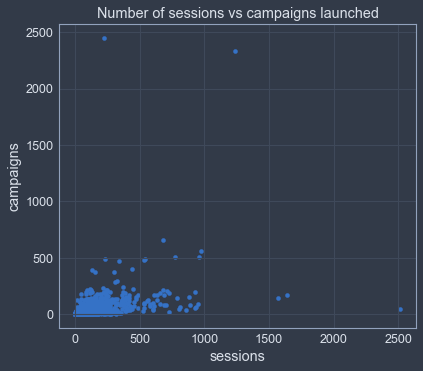

In [21]:
overall_stats.plot.scatter("sessions", "campaigns", color='b', 
                           title="Number of sessions vs campaigns launched")

In [22]:
round(overall_stats["sessions"].corr(overall_stats["campaigns"]),4)

0.5009

### Average session duration vs. campaigns launched

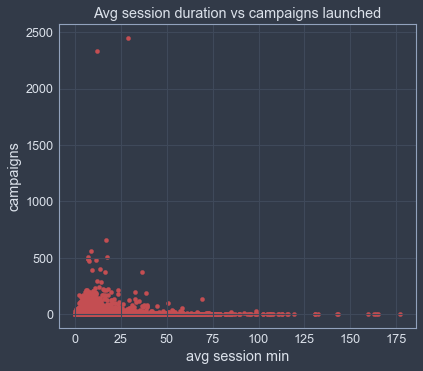

In [23]:
overall_stats.plot.scatter("avg session min", "campaigns", color='r', 
                           title="Avg session duration vs campaigns launched")

In [24]:
round(overall_stats["avg session min"].corr(overall_stats["campaigns"]),4)

0.0074

The correlation between number of sessions and number of campaigns launched is __0.5__ which is significant but not necessarily strong. The correlation between avg session minutes and campaigns launched is __.0075__ which is not significant (so no relationship). This tells me that youtube users aren't logging in to strictly launch new campaigns on a consistent basis. Most likely their initially creating campaigns and later logging in one or more times to check sales/stats.

## How many times are users visiting the site?

Breaking up users 'number of visits' categories helps split users into groups providing some insight for low traffic users vs high traffic users.

Based on the data I picked the visit categories of 1-2, 3-5, 6-10, 11-25, and > 100 visits.

In [25]:
# bin users into number of website visits
def visit_category(x):
    if x <= 2:
        category = '1-2'
    elif x >= 3 and x <= 5:
        category = '3-5'
    elif x > 5 and x <= 10:
        category = '6-10'
    elif x > 10 and x <= 25:
        category = '11-25'
    elif x > 25 and x <= 100:
        category = '26-100'
    else:
        category = '> 100'
    return(category)
overall_stats["visit_category"] = overall_stats["sessions"].apply(visit_category)

Text(0.5,1,'Site Visits')

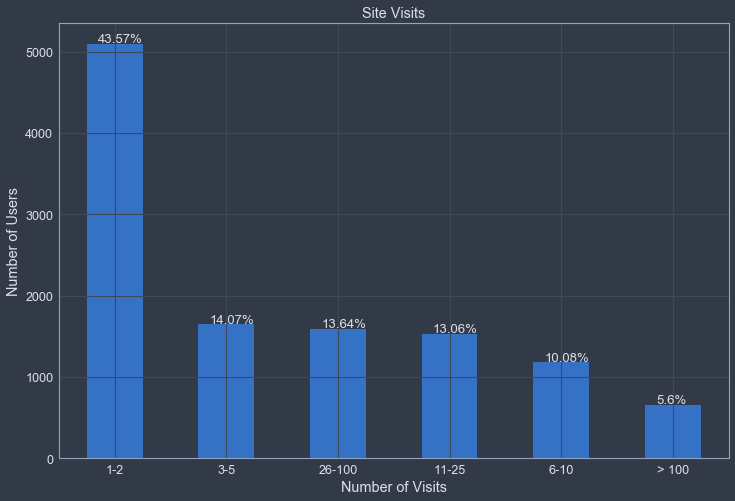

In [26]:
ax = overall_stats["visit_category"].value_counts().plot(kind='bar', figsize=(12,8), 
                                                         color='b')

# get total
totals = []
for i in ax.patches:
    totals.append(i.get_height())
total = sum(totals)

# set % of total
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+20, 
            str(round((i.get_height()/total)*100, 2))+"%")
    
# set format
for tick in ax.get_xticklabels():
    tick.set_rotation(0) # change automatic rotation to 0
ax.set_xlabel("Number of Visits")
ax.set_ylabel("Number of Users")
ax.set_title("Site Visits")

Close to half of users that sign up through youtube are signing up and possibly visiting once more before never returning. So the biggest piece of the puzzle lies in users who visit 1-2 times.

Looking at the different categories, I'm curious if there's a differnce in average launches by user in different categories. That is, do high traffic users tend to pump out more campaigns or are they simply visiting many times to check sales.

A boxplot for each group would show the distribution of average launches per visit by "Visit Category"

C:\Users\elliott.good\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


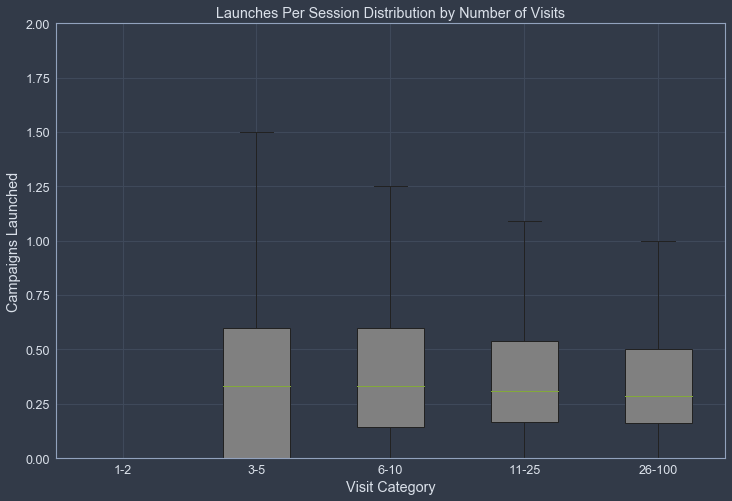

In [27]:
# plot campaign launch distribution by visit category
avg_launches = overall_stats.copy()
avg_launches["launches per session"] = avg_launches["campaigns"]/avg_launches["sessions"]

fig, ax = plt.subplots()

categories = ["1-2", "3-5", "6-10", "11-25", "26-100"] # '> 100' category skews data
campaigns_launched = []
for category in categories: # boxplot requires data be grouped in an array
    campaigns_launched.append(avg_launches[avg_launches["visit_category"] == 
                                           category]["launches per session"])

bplot = ax.boxplot(campaigns_launched, patch_artist=True)

# fill in box plots
for patch in bplot['boxes']: 
    patch.set_facecolor("gray")

fig.set_figwidth(12)
fig.set_figheight(8)

ax.set_ylim(0, 2)
ax.set_xlabel("Visit Category")
ax.set_ylabel("Campaigns Launched")
ax.set_xticklabels(categories)
ax.set_title("Launches Per Session Distribution by Number of Visits")

plt.show()

This shows that on avearage users launch close to .25 campaigns each visit _accross all visit categories_. So if we can get users to keep returning, they'll keep launching campaigns at the same rate. I'm guessing that if we can get some initial success for users who visit 1-2 times then maybe we can get them to keep returning and keep that success going.

From here I'll just look at users who visit 1-2 times to see if we can get some insight as to what they're doing after signing up.

## How long are users who visit 1-2 times visiting?

### Average time spent on site for users who visit 1-2 times

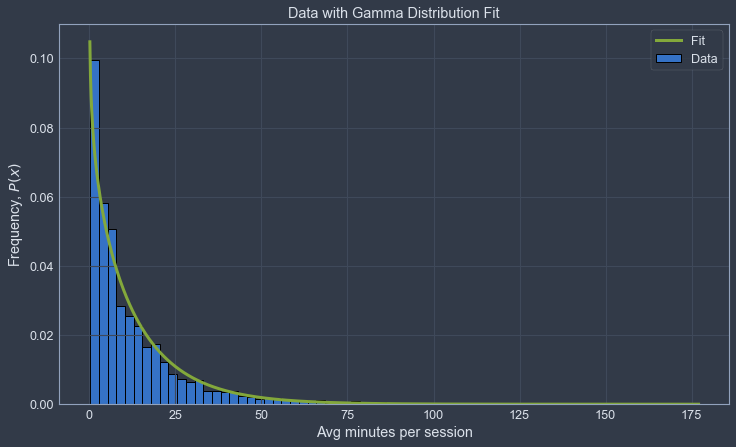

In [28]:
one_visit_users = overall_stats[overall_stats["visit_category"] == "1-2"] # low traffic users
# fit a gamma distribution
data = one_visit_users[one_visit_users["avg session min"] > 0]["avg session min"] # remove 0's
alpha_hat, loc_hat, scale_hat = stats.gamma.fit(data, floc=0) # floc=0 since we know it starts at 0

x_gamma = np.linspace(0, one_visit_users["avg session min"].max(), 1000) # generate x's
y_gamma = stats.gamma.pdf(x_gamma, alpha_hat, loc_hat, scale_hat) # fit values

fig, ax = plt.subplots()

ax.hist(data, normed=True, bins=70, label="Data", color='b',
        edgecolor='black',linewidth=1)
ax.plot(x_gamma, y_gamma, label="Fit", color='g', linewidth=3)

fig.set_figheight(7)
fig.set_figwidth(12)
ax.set_title("Data with Gamma Distribution Fit")
ax.set_xlabel("Avg minutes per session")
ax.set_ylabel("Frequency, "+r'$P(x)$')
ax.legend()

plt.show()

In [29]:
# expected value for gamma E(X) = k*theta
alpha_hat*scale_hat

13.222089155023289

The expected amount of time a user who visits 1-2 times is about __13 minutes__. Each bin is about 2.5 minutes so we can see the _biggest group are users who spend about 2.5 minutes_ on the site. So they sign up, maybe check out a few things, then quickly leave. So most likely a lot of these users aren't experiencing all teespring has to offer.

## What are 1-2 visit users doing after signing up?

In [30]:
### user activity ###
user_events = website_views.copy()
user_events["event_group"] = [i[0] for i in user_events["event_type"].str.split(".")]
user_events = user_events.drop(labels=["event_id", "session_id", "amplitude_id", "event_type", 
                         "new_session"],axis=1)

In [31]:
user_summary = user_events.groupby(by=["user_id", "session", "event_group"], as_index=False)\
    [["event_time"]].agg(["min", "max"])
user_summary.columns = user_summary.columns.droplevel(0) # drop grouped columns
user_summary = user_summary.reset_index() # drop grouped index
# get time between first and last event in event group per user/session
user_summary["time_spent"] = round((user_summary["max"] - 
                                   user_summary["min"]).dt.seconds/60,2) # convert to minutes

In [32]:
# summarize time spent in each user's event_group
user_summary = user_summary.groupby(by=["user_id", "event_group"],
                                   as_index=False)[["time_spent"]].sum()
# combine user summary with overall stats
user_summary = user_summary.merge(overall_stats, on="user_id",how="left")

### All event groupings

This list shows time spent in amplitude's "event type" categories. Each category has further detail but was truncated to show overall trends.

In [33]:
### summarize what 1-2 visit users are looking at ###
low_users_summary = user_summary[user_summary["visit_category"]=="1-2"]
low_users_summary = low_users_summary.groupby(by="event_group",as_index=False)[["time_spent"]].sum()

# get % of total, show top event groups
low_users_summary["% total"] = round(low_users_summary["time_spent"]/
                                     low_users_summary["time_spent"].sum(),4)*100
low_users_summary.sort_values("% total", ascending=False)

,event_group,time_spent,% total
35,launcher,48928.17,33.61
32,header,19031.06,13.07
6,campaigns_show,11304.13,7.76
46,referrer_viewed,11039.90,7.58
33,homepage_show,10197.76,7.00
14,composer,8958.53,6.15
18,dashboard_campaigns,8345.56,5.73
37,optimizely,4668.38,3.21
16,dashboard_account_settings,3953.00,2.72
51,stores_index,3795.36,2.61


Since there are so many groups I'll categorize anything under 1% of total as "other"

In [34]:
# filter down event groups so that everything below a threshold is merged into 'other'
low_users_summary["event_category"] = low_users_summary.apply(
    lambda row: row["event_group"] if row["% total"] > .50 else 'other',axis=1)
# sum 'other'
low_users_summary = low_users_summary.groupby(by="event_category", as_index=False).sum()

In [35]:
low_users_summary.sort_values("% total", ascending=False, inplace=True)
low_users_summary.reset_index(inplace=True)
low_users_summary.drop(labels=["index"], axis=1, inplace=True)

### Event Categories % Time Spent for 1-2 Visit Users

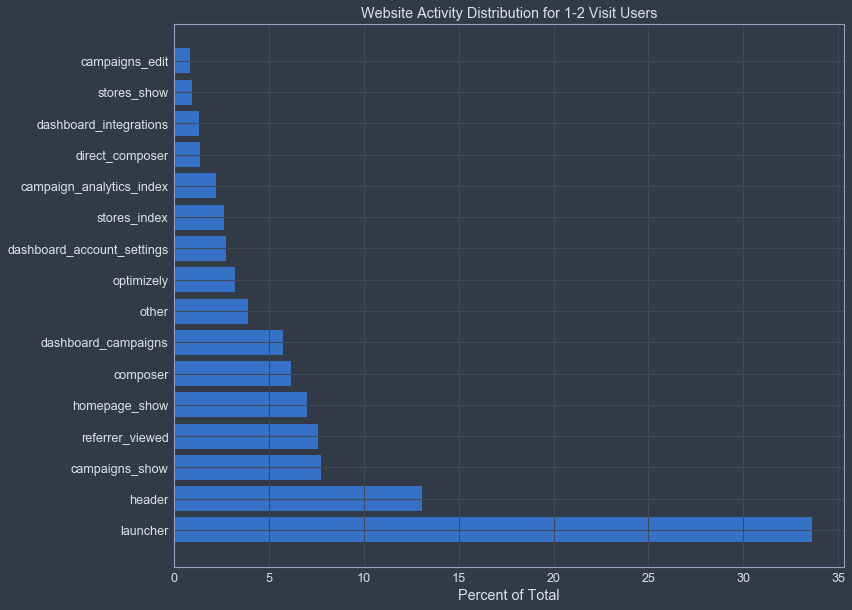

In [36]:
fig, ax = plt.subplots()

fig.set_figwidth(12)
fig.set_figheight(10)

# in order to order by biggest to smallest we have to plot % total with dummy index
# then manually change index the number of categories in our list (yticks) then
# set the lables to our categories (yticklabels)
ax.barh(range(len(low_users_summary)),low_users_summary["% total"])
ax.set_yticks(range(len(low_users_summary)))
ax.set_yticklabels(low_users_summary["event_category"])

ax.set_xlabel("Percent of Total")
# ax.set_ylabel("Event Category")
ax.set_title("Website Activity Distribution for 1-2 Visit Users")

plt.show()

Most of the time users are working in the launcher. The top 50% are launcher, header, and campaigns_show. I'm not sure what 'header' refers to but the other two indicates users are primarily working in launcher and reviewing their campaigns.

This data might be skewed due to the outlier users that spend > 30 minutes in their 1-2 sessions. If we break it down by splitting out these two groups we get the below graph.

In [37]:
### Split users into two groups - those below and those above 30 min avg session time ###
low_user_split = user_summary.loc[user_summary["visit_category"]=="1-2",:]
low_user_split.is_copy = False # explicitly show this sub-dataframe is not a copy but a new dataframe (no caveat)
low_user_split["user_type"] = low_user_split.loc[:,"avg session min"].apply(
    lambda x: "< 30 min" if x < 30.0 else ">= 30 min") # split users
low_user_split = low_user_split.groupby(by=["event_group", "user_type"],
                                        as_index=False)[["time_spent"]].sum()

# pivot user type column
low_user_split = low_user_split.pivot_table("time_spent", "event_group", "user_type")
low_user_split.reset_index(inplace=True)
# add total time, % column total
low_user_split["total_time"] = low_user_split["< 30 min"] + low_user_split[">= 30 min"]
low_user_split["% Column Total"] = round(low_user_split["total_time"]/low_user_split["total_time"].sum(),4)*100
# filter down event groups so that everything below a threshold is merged into 'other'
low_user_split["event_category"] = low_user_split.apply(
    lambda row: row["event_group"] if row["% Column Total"] > .50 else 'other',axis=1)
# sum 'other'
low_user_split = low_user_split.groupby(by="event_category", as_index=False).sum()
# get % of user groups
low_user_split["< 30 min % total"] = round(low_user_split["< 30 min"]/
                                           low_user_split["total_time"],4)*100
low_user_split[">= 30 min % total"] = round(low_user_split[">= 30 min"]/
                                            low_user_split["total_time"],4)*100
low_user_split.fillna(value=0,inplace=True) # replace NA's with 0
# sort values
low_user_split.sort_values("% Column Total", ascending=False, inplace=True)
low_user_split.reset_index(inplace=True)
low_user_split.drop(labels=["index"], axis=1, inplace=True)

low_user_split

user_type,event_category,< 30 min,>= 30 min,total_time,% Column Total,< 30 min % total,>= 30 min % total
0,launcher,25668.38,23259.79,48928.17,33.61,52.46,47.54
1,header,7280.20,11750.86,19031.06,13.07,38.25,61.75
2,campaigns_show,3345.77,7958.36,11304.13,7.76,29.60,70.40
3,referrer_viewed,3196.01,7843.89,11039.90,7.58,28.95,71.05
4,homepage_show,3421.06,6776.70,10197.76,7.00,33.55,66.45
5,composer,4408.35,4550.18,8958.53,6.15,49.21,50.79
6,dashboard_campaigns,2490.24,5855.32,8345.56,5.73,29.84,70.16
7,other,1539.79,4126.80,5666.59,3.90,27.17,72.83
8,optimizely,1463.37,3205.01,4668.38,3.21,31.35,68.65
9,dashboard_account_settings,1503.86,2449.14,3953.00,2.72,38.04,61.96


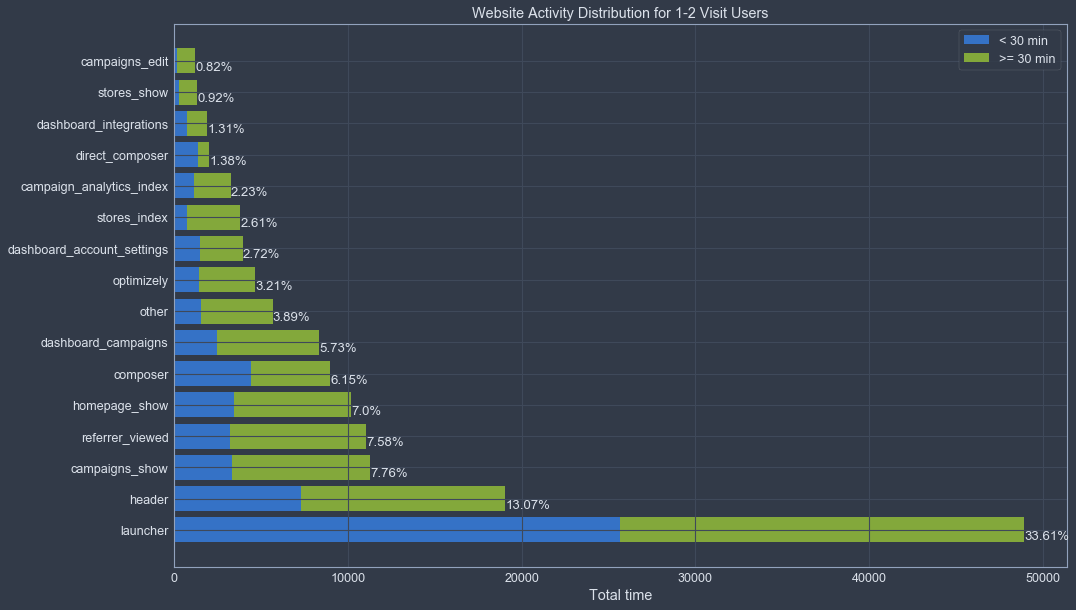

In [38]:
fig, ax = plt.subplots()

fig.set_figwidth(16)
fig.set_figheight(10)

ax.barh(range(len(low_user_split)), low_user_split["< 30 min"], label="< 30 min")
ax.barh(range(len(low_user_split)), low_user_split[">= 30 min"], 
        left=low_user_split["< 30 min"], label=">= 30 min")

ax.set_yticks(range(len(low_user_split)))
ax.set_yticklabels(low_user_split["event_category"])

total= low_user_split["total_time"].sum()

# add % Total values to right of bars
for i in ax.patches:
    if i.get_x() > 0: # skip bottom stack of bars
        ax.text((i.get_x()+i.get_width())+20, i.get_y()+.1, 
            str(round(((i.get_x()+i.get_width())/total)*100, 2))+"%")

ax.set_xlabel("Total time")
# ax.set_ylabel("Event Category")
ax.set_title("Website Activity Distribution for 1-2 Visit Users")


ax.legend()
plt.show()

This tells about the same story except we can replace the top three with launcher, header, and composer instead of campaigns_launched.

So new users that visit only 1-2 times are spending half of their time toying with launching campaigns and the rest is scattered throughout the site.